# Placeholder Barplots
These are **NOT** experimental results! This is only the pipeline for the visualization.

In [1]:
from typing import Dict
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
from barplots import barplots
from itertools import product
import os

def sample(dictionary:Dict)->Dict:
    return {
        metric: data["type"](np.random.uniform(
            low=data["min"],
            high=data["max"]
        ))
        for metric, data in dictionary.items()
    }

## Metric ranges
The ranges of the fake results and parameters

In [2]:
metrics = {
    "AUROC":{"min":0.5, "max":1, "type":float},
    "AUPRC":{"min":0, "max":1, "type":float},
    "MCC":{"min":-1, "max":1, "type":float},
    "Accuracy":{"min":0.5, "max":1, "type":float},
    "F1Score":{"min":0, "max":1, "type":float},
}
outer_holdouts = 10
inner_holdouts = 3
phase_one_random_samples = 100
phase_two_bo_samples = 100
phase_three_random_samples = 100
phase_three_bo_samples = 100
quality_metric = "MCC"
threshold = 0.01

edge_embedding_methods = [
    "Hadamart", "L1", "L2", "Average"
]
node_embedding_models = [
    "GloVe", "CBOW", "SkipGram"
]
link_prediction_models = [
    "FFNN", "Random Forest", "Logistic Regression"
]
graphs = [
    "PPI", "GGI"
]
run_types = [
    "train", "test"
]
node_parameters = {
    "p":{"min":0.0001, "max":10, "type":float},
    "q":{"min":0.0001, "max":10, "type":float},
    "walk_length":{"min":30, "max":1000, "type":int},
    "embedding_size":{"min":10, "max":200, "type":int},
    "window_size":{"min":1, "max":10, "type":int},
    "iterations":{"min":1, "max":50, "type":int},
    "negative_samples":{"min":1, "max":1000, "type":int},
    "learning_rate":{"min":0.0001, "max":1, "type":float}
}
ffnn_parameters = {
    "length_block_1":{"min":0, "max":10, "type":int},
    "width_block_1":{"min":0, "max":2048, "type":int},
    "learning_rate":{"min":0.0001, "max":1, "type":float}
}

## Creating the fake data of the first phase

In [3]:
datapoints = [
    sample(node_parameters)
    for _ in range(phase_one_random_samples)
]

first_phase = pd.DataFrame([
    {
        **sample(metrics),
        **datapoint,
        "edge_embedding_method":edge_embedding_method,
        "link_prediction_model":"Logistic Regression",
        "graph":graph,
        "run_type":run_type,
        "outer":outer,
        "inner":inner
    }
    for edge_embedding_method in tqdm(
        edge_embedding_methods,
        desc="Computing fake datapoints",
        leave=False
    )
    for datapoint in datapoints
    for outer in range(outer_holdouts)
    for inner in range(inner_holdouts)
    for node_embedding_model in node_embedding_models
    for graph in graphs
    for run_type in run_types
])

### Find optimal (fake) edge embedding method for each outer holdout

In [4]:
from scipy.stats import wilcoxon

phase_one_wilcoxon_tests = []

for outer in trange(outer_holdouts):
    for graph in graphs:
        filtered = first_phase[
            (first_phase.run_type=="test") &
            (first_phase.graph==graph) &
            (first_phase.outer==outer)
        ]
        for edge_embedding_method1, edge_embedding_method2 in product(edge_embedding_methods, edge_embedding_methods):
            if edge_embedding_method1 >= edge_embedding_method2:
                continue
            results_method1 = filtered[filtered.edge_embedding_method==edge_embedding_method1][quality_metric].values
            results_method2 = filtered[filtered.edge_embedding_method==edge_embedding_method2][quality_metric].values
            stat, p_value = wilcoxon(results_method1, results_method2)
            win, tie, loss = 0, 0, 0
            if p_value >= threshold:
                tie = 1
            elif results_method1.mean() > results_method2.mean():
                win = 1
            else:
                loss = 1
            for method, results in zip(
                (edge_embedding_method1, edge_embedding_method2),
                ((win, tie, loss), (loss, tie, win))
            ):
                for result, value in zip(
                    ("win", "tie", "loss"),
                    results
                ):
                    phase_one_wilcoxon_tests.append({
                        "edge_embedding_method":method,
                        "result":result,
                        "count": value,
                        "outer":outer,
                        "graph":graph
                    })

phase_one_best_edge_embedding_method = pd.DataFrame(phase_one_wilcoxon_tests).groupby([
    "graph", "outer", "edge_embedding_method"
]).sum().sort_values(
    "count"
).groupby(["graph", "outer"]).tail(1).reset_index()

phase_one_wilcoxon_tests_sums = pd.DataFrame(phase_one_wilcoxon_tests).groupby([
    "graph", "edge_embedding_method", "result"
]).sum().drop(columns="outer")


# Temporarily replace value with random samples:
phase_one_wilcoxon_tests_sums["count"] = [
    int(value/random_values.sum()*phase_one_wilcoxon_tests_sums["count"].max())
    for random_values in np.random.uniform(size=(len(phase_one_wilcoxon_tests_sums)//3, 3))
    for value in random_values
]

### Plotting the win tie loss

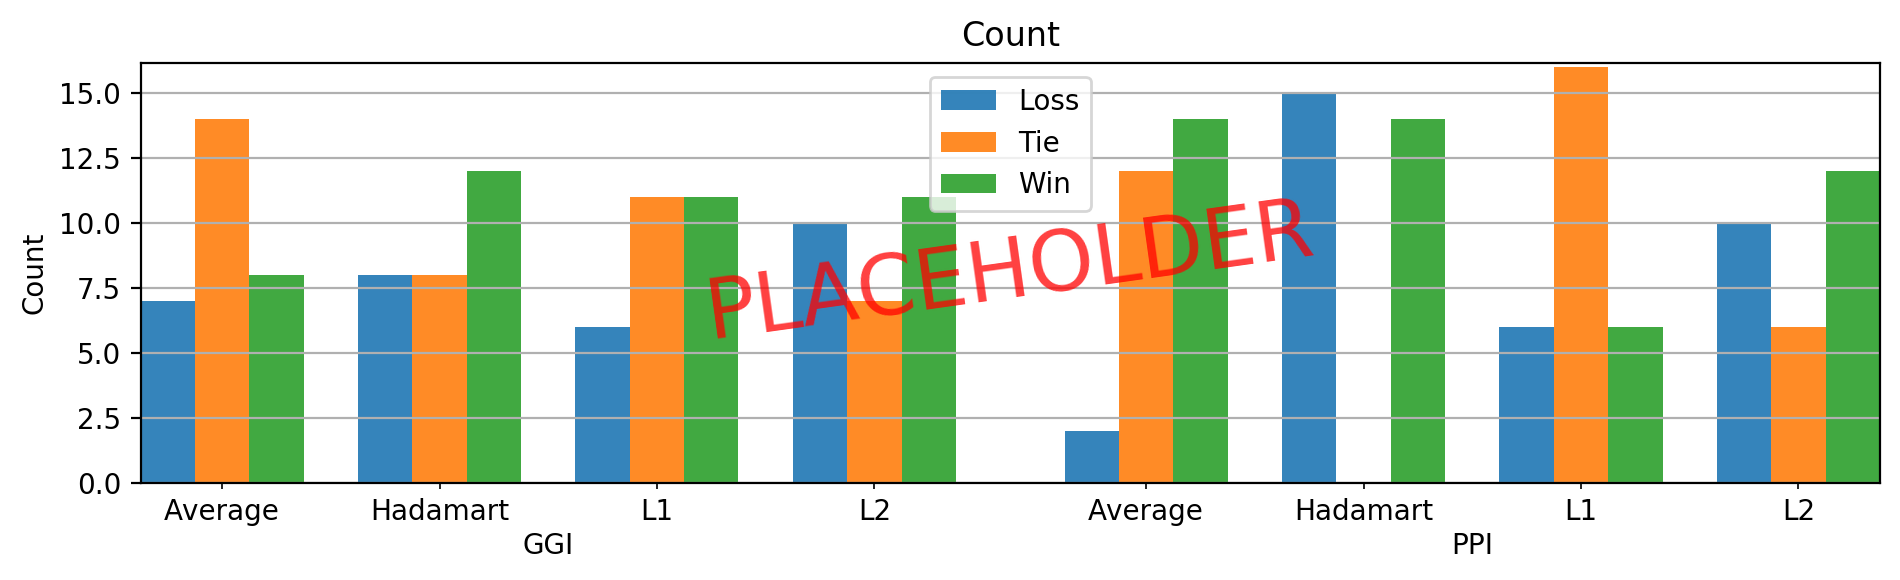

In [5]:
from IPython.display import display, Image
from glob import glob
import matplotlib.pyplot as plt
import shutil

figures, axes = barplots(
    phase_one_wilcoxon_tests_sums,
    groupby=["graph", "edge_embedding_method", "result"],
    show_standard_deviation=False,
    legend_position="upper center",
    path="barplots/edge_embedding_method_count.jpg",
    placeholder=True,
    height=3
)

## Creating the fake data of the second phase

In [6]:
second_phase = pd.DataFrame([
    {
        **sample(metrics),
        **sample(node_parameters),
        "edge_embedding_method":phase_one_best_edge_embedding_method[
            (phase_one_best_edge_embedding_method.outer==outer) &
            (phase_one_best_edge_embedding_method.graph==graph)
        ].iloc[0]["edge_embedding_method"],
        "node_embedding_model":node_embedding_model,
        "link_prediction_model":"Logistic Regression",
        "graph":graph,
        "run_type":run_type,
        "outer":outer,
        "inner":inner
    }
    for edge_embedding_method in tqdm(
        edge_embedding_methods,
        desc="Computing fake datapoints",
        leave=False
    )
    for _ in range(phase_two_bo_samples)
    for outer in range(outer_holdouts)
    for inner in range(inner_holdouts)
    for node_embedding_model in node_embedding_models
    for graph in graphs
    for run_type in run_types
])

### Find optimal embedding from second phase

In [7]:
optimal_embeddings = second_phase[second_phase.run_type=="test"].drop(
    columns=["inner"]
).sort_values(
    quality_metric
).groupby(["graph", "outer", "node_embedding_model"]).tail(1)

## Creating the fake data of the third phase

In [8]:
third_phase = pd.DataFrame([
    {
        **sample(metrics),
        **sample(ffnn_parameters),
        **optimal_embeddings[
            (optimal_embeddings.outer==outer) &
            (optimal_embeddings.graph==graph) &
            (optimal_embeddings.node_embedding_model == node_embedding_model)
        ].iloc[0].to_dict(),
        "edge_embedding_method":phase_one_best_edge_embedding_method[
            (phase_one_best_edge_embedding_method.outer==outer) &
            (phase_one_best_edge_embedding_method.graph==graph)
        ].iloc[0]["edge_embedding_method"],
        "link_prediction_model":"FFNN",
        "graph":graph,
        "run_type":run_type,
        "outer":outer,
        "inner":inner
    }
    for _ in trange(phase_three_random_samples + phase_three_bo_samples)
    for outer in range(outer_holdouts)
    for inner in range(inner_holdouts)
    for node_embedding_model in node_embedding_models
    for graph in graphs
    for run_type in run_types
])

## Computing all link prediction models performance on outer holdouts

In [9]:
link_prediction_models_results = pd.DataFrame([
    {
        **optimal_embeddings[
            (optimal_embeddings.outer==outer) &
            (optimal_embeddings.graph==graph) &
            (optimal_embeddings.node_embedding_model == node_embedding_model)
        ].iloc[0].to_dict(),
        **sample(metrics),
        "link_prediction_model":model,
        "graph":graph,
        "run_type":run_type,
        "outer":outer
    }
    for model in tqdm(link_prediction_models)
    for outer in range(outer_holdouts)
    for node_embedding_model in node_embedding_models
    for graph in graphs
    for run_type in run_types
])

In [10]:
link_prediction_models_results

,AUROC,AUPRC,MCC,Accuracy,F1Score,p,q,walk_length,embedding_size,window_size,iterations,negative_samples,learning_rate,edge_embedding_method,node_embedding_model,link_prediction_model,graph,run_type,outer
0,0.869037,0.048628,0.561934,0.505381,0.726195,9.326944,7.070037,868,153,1,2,769,0.199260,Average,GloVe,FFNN,PPI,train,0
1,0.990051,0.752369,0.117209,0.556983,0.848575,9.326944,7.070037,868,153,1,2,769,0.199260,Average,GloVe,FFNN,PPI,test,0
2,0.957160,0.110163,-0.892917,0.749319,0.199930,2.873235,6.427422,57,94,7,24,180,0.885440,Hadamart,GloVe,FFNN,GGI,train,0
3,0.802949,0.297215,0.698852,0.522910,0.990249,2.873235,6.427422,57,94,7,24,180,0.885440,Hadamart,GloVe,FFNN,GGI,test,0
4,0.835793,0.654270,0.610282,0.536355,0.269323,6.627013,4.730894,695,53,5,30,880,0.050247,Average,CBOW,FFNN,PPI,train,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.551632,0.399289,-0.089933,0.752841,0.574477,8.939187,7.008067,452,130,8,34,630,0.984967,Average,CBOW,Logistic Regression,GGI,test,9
356,0.579112,0.913687,-0.101813,0.933980,0.305000,4.470968,7.842120,406,167,6,20,233,0.547094,L2,SkipGram,Logistic Regression,PPI,train,9
357,0.769994,0.215636,-0.680115,0.901246,0.394994,4.470968,7.842120,406,167,6,20,233,0.547094,L2,SkipGram,Logistic Regression,PPI,test,9
358,0.820033,0.497046,0.252101,0.925968,0.504439,8.058811,9.507752,103,52,9,40,29,0.225535,Average,SkipGram,Logistic Regression,GGI,train,9


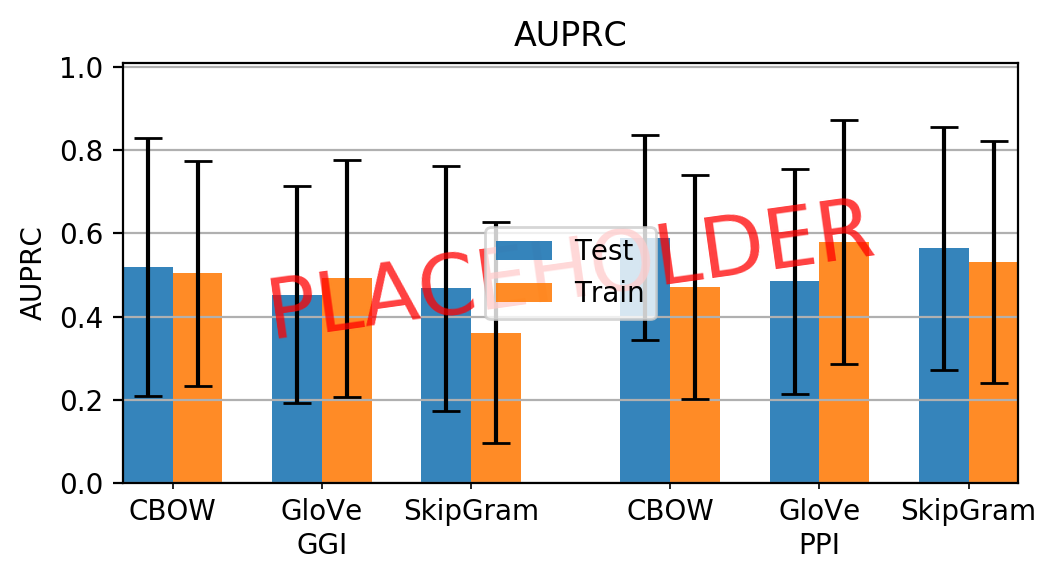

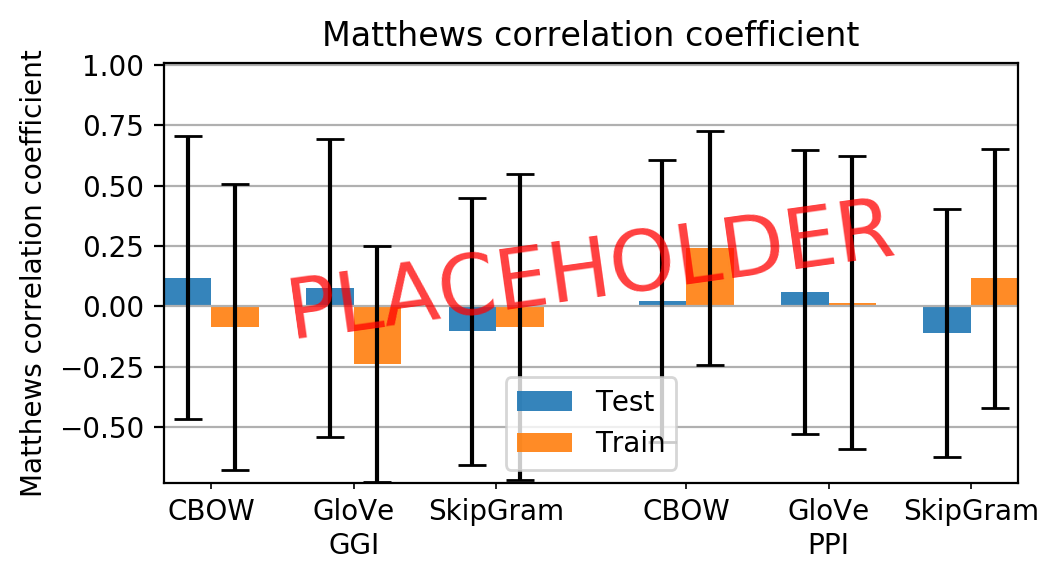

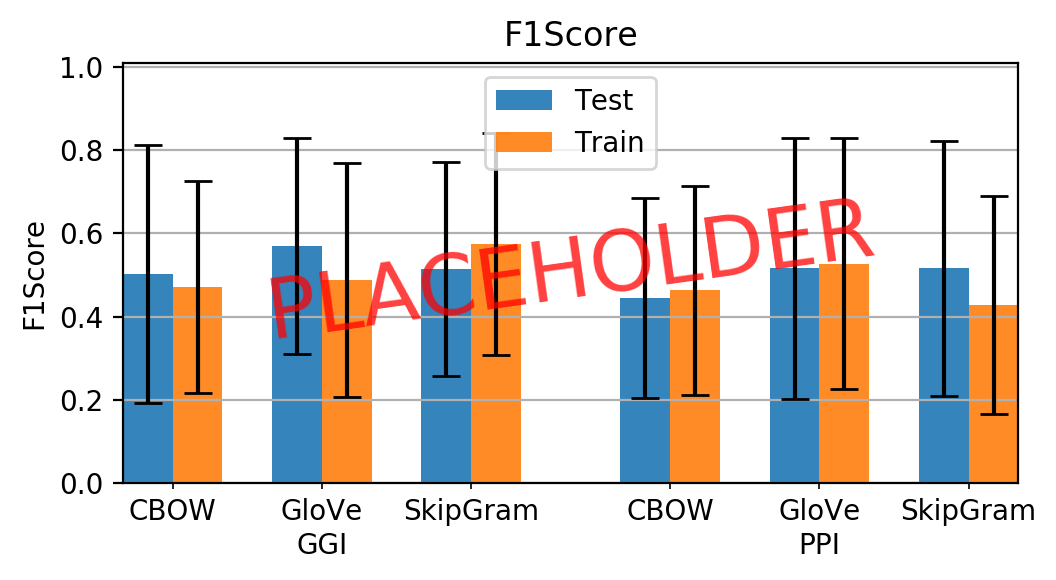

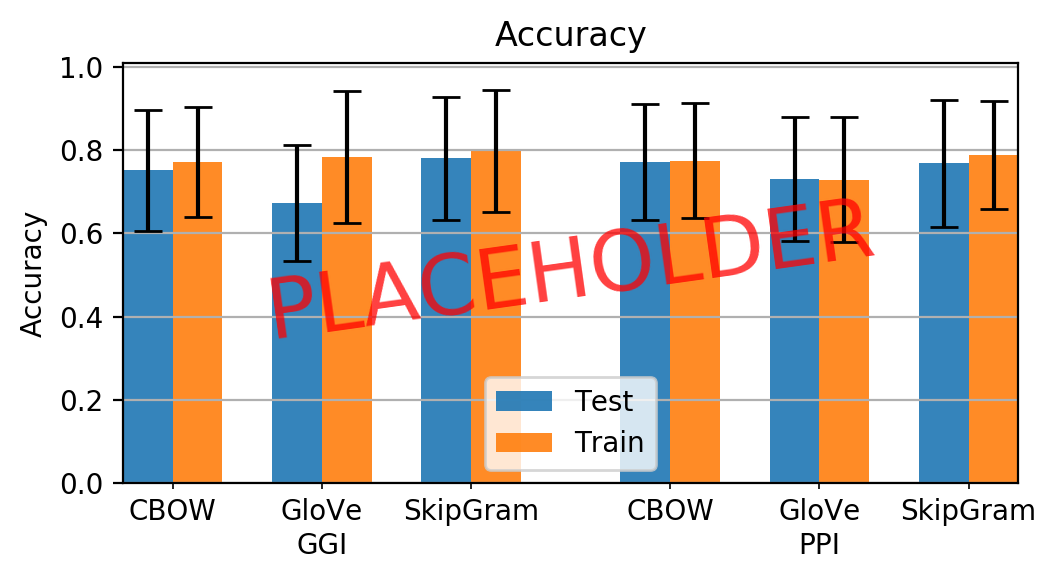

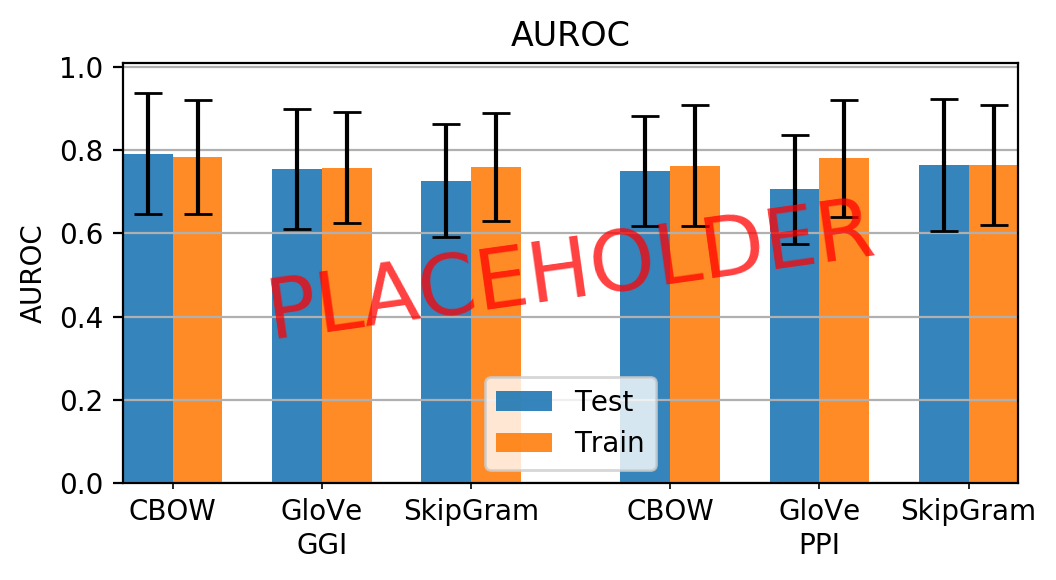

In [11]:
root = "barplots/node_embedding"

if os.path.exists(root):
    shutil.rmtree(root)

groups = ["graph", "node_embedding_model", "run_type"]
figures, axes = barplots(
    link_prediction_models_results[groups+list(metrics.keys())],
    groupby=groups,
    path=f"{root}/{{feature}}.jpg",
    placeholder=True,
    height=3
)

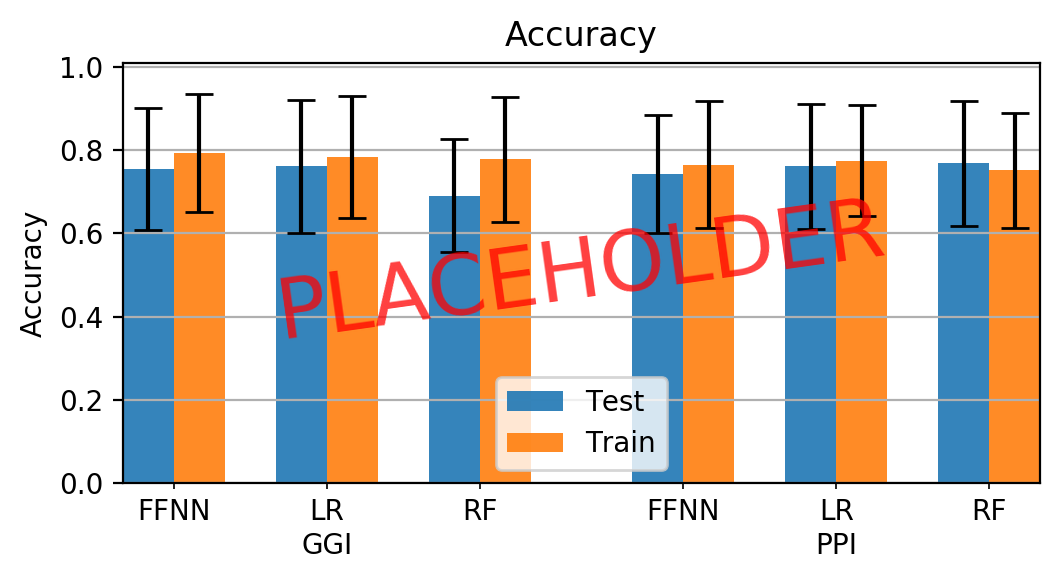

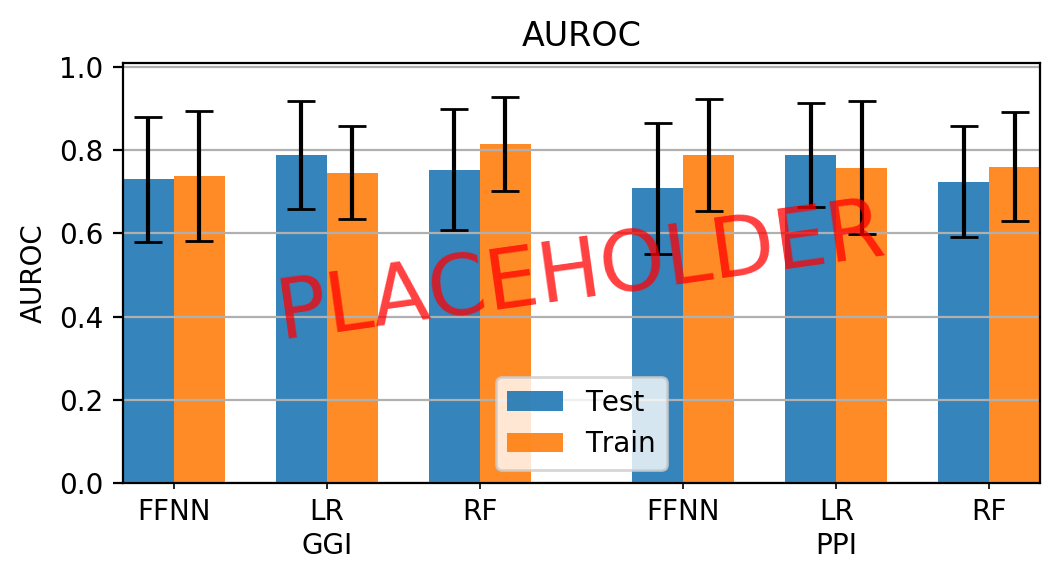

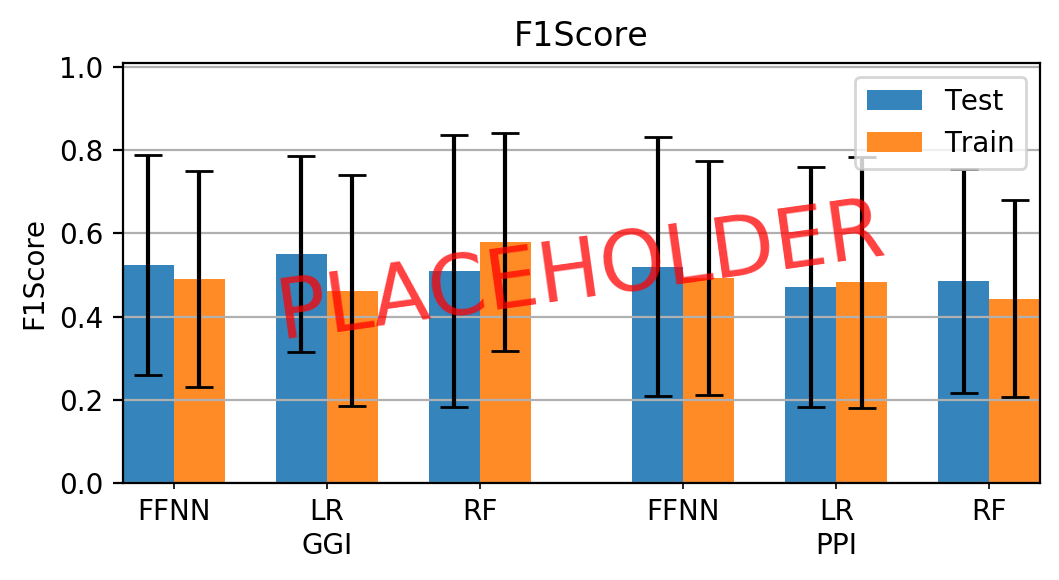

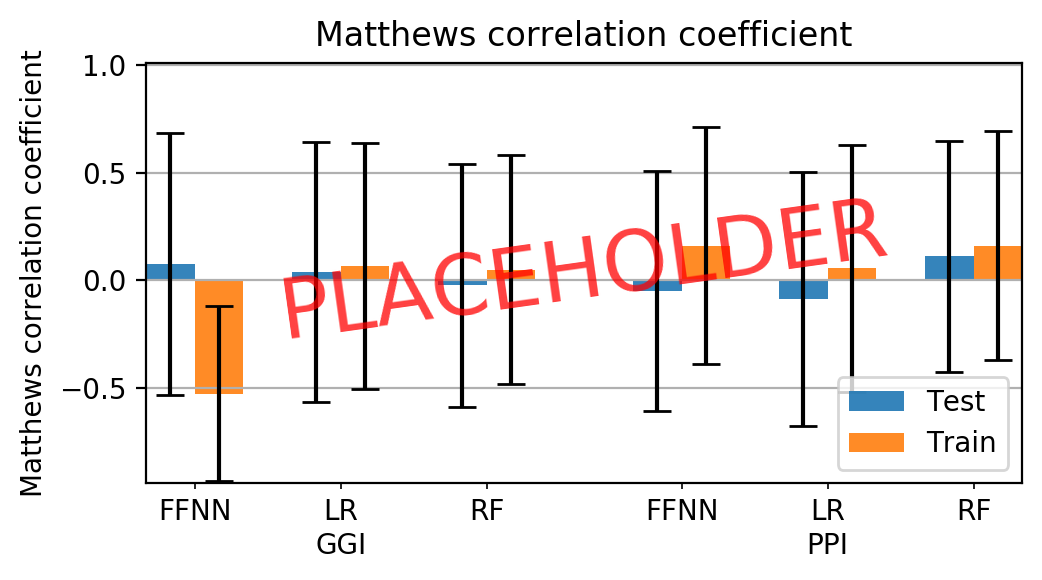

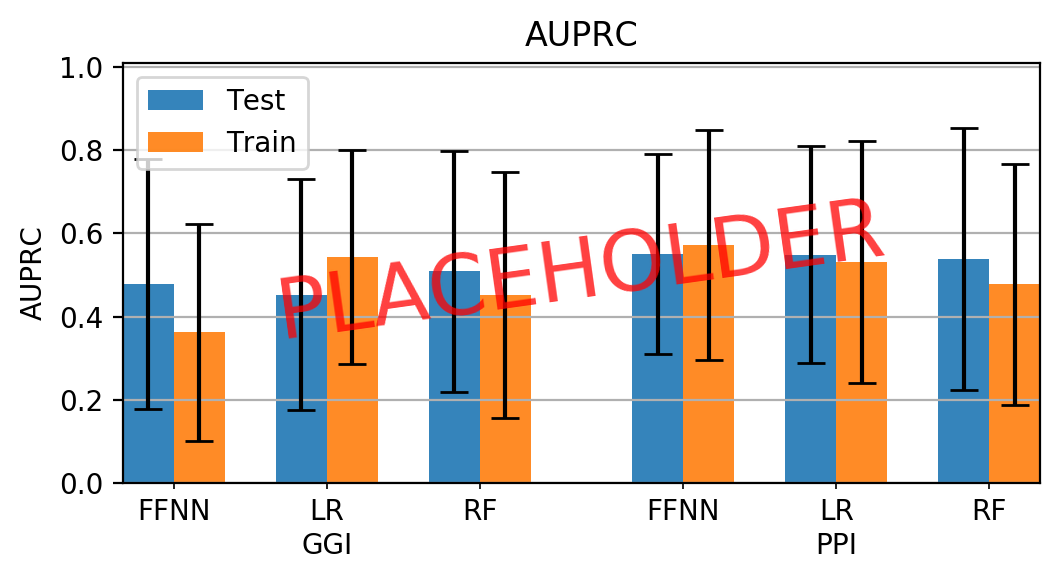

In [12]:
root = "barplots/link_prediction"

if os.path.exists(root):
    shutil.rmtree(root)

groups = ["graph", "link_prediction_model", "run_type"]
figures, axes = barplots(
    link_prediction_models_results[groups+list(metrics.keys())],
    groupby=groups,
    path=f"{root}/{{feature}}.jpg",
    placeholder=True,
    height=3,
    custom_defaults={
        "LR":["Logistic regression"],
        "RF":["Random Forest"],
    }
)

In [13]:
from scipy.stats import wilcoxon

node_model_comparison_wilcoxon_tests = []
link_prediction_model_comparison_wilcoxon_tests = []

for graph in graphs:
    filtered = link_prediction_models_results[
        (link_prediction_models_results.run_type=="test") &
        (link_prediction_models_results.graph==graph)
    ]
    for i, node_embedding1 in enumerate(node_embedding_models):
        for node_embedding2 in node_embedding_models[i+1:]:
            if node_embedding1 == node_embedding2:
                continue
            results_method1 = filtered[filtered.node_embedding_model==node_embedding1][quality_metric].values
            results_method2 = filtered[filtered.node_embedding_model==node_embedding2][quality_metric].values
            stat, p_value = wilcoxon(results_method1, results_method2)
            win, tie, loss = 0, 0, 0
            if p_value >= threshold:
                tie = 1
            elif results_method1.mean() > results_method2.mean():
                win = 1
            else:
                loss = 1
            for method, results in zip(
                (node_embedding1, node_embedding2),
                ((win, tie, loss), (loss, tie, win))
            ):
                for result, value in zip(
                    ("win", "tie", "loss"),
                    results
                ):
                    node_model_comparison_wilcoxon_tests.append({
                        "node_embedding_model":method,
                        "result":result,
                        "count": value,
                        "graph":graph
                    })
    for i, link_model1 in enumerate(link_prediction_models):
        for link_model2 in link_prediction_models[i+1:]:
            if link_model1 == link_model2:
                continue
            results_method1 = filtered[filtered.link_prediction_model==link_model1][quality_metric].values
            results_method2 = filtered[filtered.link_prediction_model==link_model2][quality_metric].values
            stat, p_value = wilcoxon(results_method1, results_method2)
            win, tie, loss = 0, 0, 0
            if p_value >= threshold:
                tie = 1
            elif results_method1.mean() > results_method2.mean():
                win = 1
            else:
                loss = 1
            for method, results in zip(
                (link_model1, link_model2),
                ((win, tie, loss), (loss, tie, win))
            ):
                for result, value in zip(
                    ("win", "tie", "loss"),
                    results
                ):
                    link_prediction_model_comparison_wilcoxon_tests.append({
                        "link_prediction_model":method,
                        "result":result,
                        "count": value,
                        "graph":graph
                    })
                    
best_node_embedding_method_sums = pd.DataFrame(node_model_comparison_wilcoxon_tests).groupby([
    "graph", "node_embedding_model", "result"
]).sum()

link_model_method_sums = pd.DataFrame(link_prediction_model_comparison_wilcoxon_tests).groupby([
    "graph", "link_prediction_model", "result"
]).sum()

# Temporarily replace value with random samples:
best_node_embedding_method_sums["count"] = [
    value
    for _ in range(len(best_node_embedding_method_sums)//3)
    for value in (1, 0, 1)
]
# Temporarily replace value with random samples:
link_model_method_sums["count"] = [
    value
    for _ in range(len(link_model_method_sums)//3)
    for value in (1, 0, 1)
]

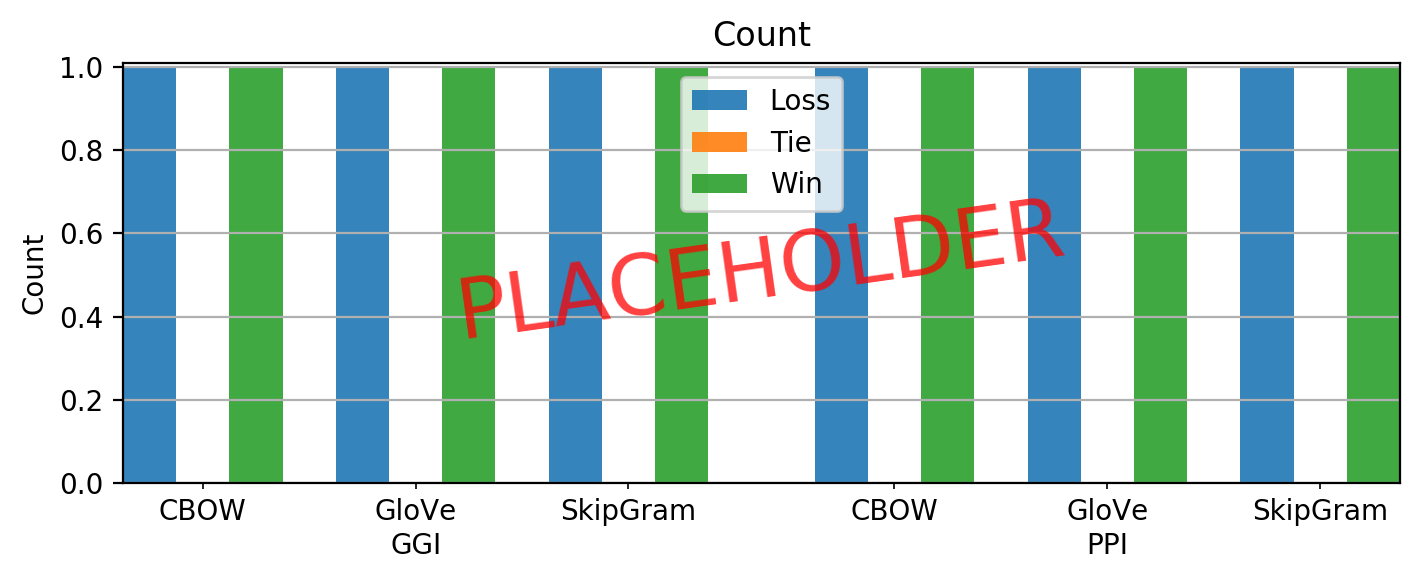

In [14]:
root = "barplots/node_embedding"

if os.path.exists(root):
    shutil.rmtree(root)
    
figures, axes = barplots(
    best_node_embedding_method_sums,
    groupby=["graph", "node_embedding_model", "result"],
    show_standard_deviation=False,
    legend_position="upper center",
    path=f"{root}/{{feature}}.jpg",
    placeholder=True,
    height=3
)

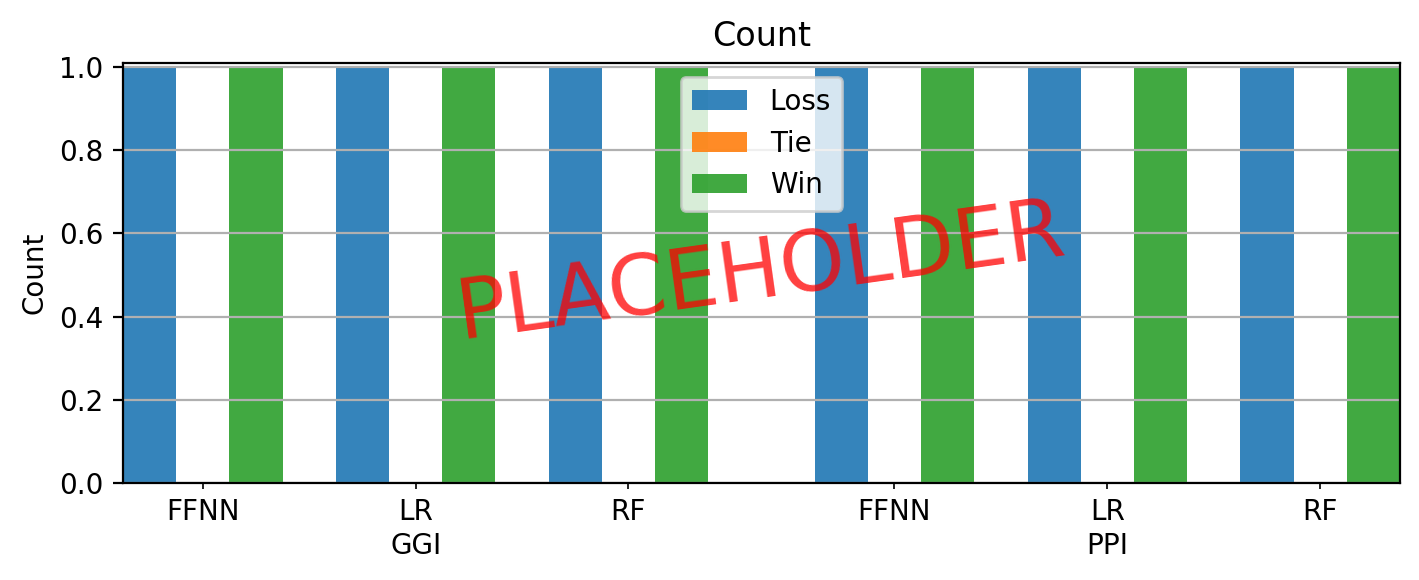

In [15]:
root = "barplots/link_prediction"

if os.path.exists(root):
    shutil.rmtree(root)
    
figures, axes = barplots(
    link_model_method_sums,
    groupby=["graph", "link_prediction_model", "result"],
    show_standard_deviation=False,
    legend_position="upper center",
    path=f"{root}/{{feature}}.jpg",
    placeholder=True,
    height=3,
    custom_defaults={
        "LR":["Logistic regression"],
        "RF":["Random Forest"],
    }
)

In [16]:
def plot_parameter_metric_correlation(data, param_name, metric_name, ax, **kwargs):
    parameter, metric = data[[param_name, metric_name]].values.T

    indices = pd.qcut(parameter, 100, labels=False)

    parameter_median, metric_mean, metric_std = np.array(list(zip(*[
        (
            np.median(parameter[i==indices]),
            np.mean(metric[i==indices]),
            np.std(metric[i==indices])
        )
        for i in np.unique(indices)
    ])))
        
    ax.fill_between(
        parameter_median,
        metric_mean-metric_std,
        metric_mean+metric_std,
        alpha=0.3
    )
    ax.plot(parameter_median, metric_mean, **kwargs)
    

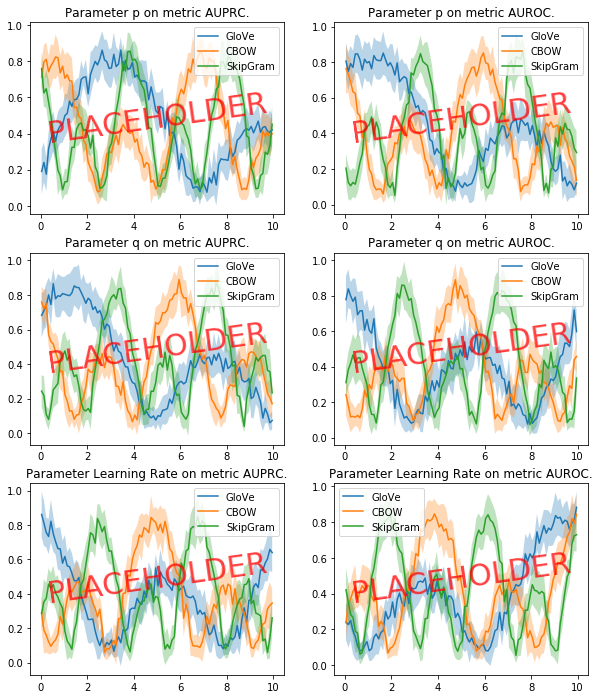

In [17]:
fig, ax = plt.subplots(
    ncols=2,
    nrows=3,
    figsize=(10, 12)
)

for k, param in enumerate(("p", "q", "Learning Rate")):
    for j, metric in enumerate(("AUPRC", "AUROC")):
        for i, model in enumerate(node_embedding_models):
            points = np.linspace(0, 10, num=1000)
            test_data = pd.DataFrame({
                param:points,
                metric:np.abs(np.random.uniform(high=0.6, size=len(points)) + np.sin(j+k+i+(i+1)*0.5*points))
            })
            test_data[metric]/=test_data[metric].max()
            plot_parameter_metric_correlation(
                test_data,
                param,
                metric,
                ax[k][j],
                label=model
            )
        ax[k][j].set_title(f"Parameter {param} on metric {metric}.")
        ax[k][j].text(
            0.5, 0.5,
            "PLACEHOLDER",
            fontsize=30,
            alpha=0.75,
            color="red",
            rotation=8,
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax[k][j].transAxes
        )
        ax[k][j].legend()
fig.savefig("performance_correlations.jpg")
plt.show()